# Sprint 3

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
from fastai.vision.all import PILImage

Loading dataset

In [2]:
# (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# X_train_full = X_train_full.astype(np.float32) / 255
# X_test = X_test.astype(np.float32) / 255
# X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
# y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

IMG_HEIGHT = 128
IMG_WIDTH = 128
img_folder = "tripadvisor_dataset/tripadvisor_mini"

def create_dataset(img_folder, n=None):
    # n = amount of images
    image_files=os.listdir(os.path.join(img_folder))
    if n==None:
        n=len(image_files)
    images = np.zeros((n, IMG_HEIGHT, IMG_WIDTH, 3))
    for i,file in enumerate(image_files[:n]):
        # print(f"{i},{file}")
        img=PILImage.create(os.path.join(img_folder,file))
        img_resized=img.resize((IMG_HEIGHT,IMG_WIDTH))
        img_np = np.array(img_resized) #.reshape((IMG_HEIGHT,IMG_WIDTH, 3)) #.astype(np.float32)
        images[i]=img_np/255
    return images

images = create_dataset(img_folder)
images_length = len(images)
X_train_full = images
X_train_full.shape

(6, 128, 128, 3)

In [27]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([128, 128, 3], input_shape=[128, 128, 3]),
    keras.layers.Conv2D(48, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(96, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(192, kernel_size=3, padding="SAME", activation="selu"), 
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(96, kernel_size=3, strides=2, padding="SAME", activation="selu",
                                 input_shape=[16, 16, 192]),
    keras.layers.Conv2DTranspose(48, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])


conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train_full, X_train_full, epochs=5)

# print(conv_encoder.summary())
# conv_decoder.summary()




Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.6947 - rounded_accuracy: 0.4896
Epoch 2/5
1/1 [==============================] - 0s 253ms/step - loss: 0.6894 - rounded_accuracy: 0.5916
Epoch 3/5
1/1 [==============================] - 0s 202ms/step - loss: 0.6854 - rounded_accuracy: 0.6380
Epoch 4/5
1/1 [==============================] - 0s 211ms/step - loss: 0.6822 - rounded_accuracy: 0.6551
Epoch 5/5
1/1 [==============================] - 0s 234ms/step - loss: 0.6796 - rounded_accuracy: 0.6621


1/1 [==============================] - 0s 51ms/step


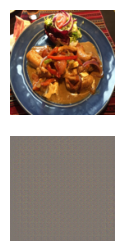

In [30]:
import matplotlib.pyplot as plt


def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")


def show_reconstructions(model, images=X_train_full, n_images=1):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])


show_reconstructions(conv_ae)
plt.show()
